In [175]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import os


titanic_train = pd.read_csv("titanic/train.csv")
titanic_test_lack = pd.read_csv("titanic/test.csv")
titanic_test_Survived = pd.read_csv("titanic/gender_submission.csv")
titanic_test = pd.merge(titanic_test_lack, titanic_test_Survived, on='PassengerId', how='inner')
titanic_train.head(5)
fare_mean = titanic_train['Fare'].mean()
fare_median  = titanic_train['Fare'].median()
fare_mean,fare_median

(32.204207968574636, 14.4542)

In [176]:
sex_map = {'male' : 1, 'female' : 0}
cabin_map=titanic_train['Cabin'].notna().astype(int)

titanic_test['Cabin_Indicator'] = cabin_map
titanic_test['Sex_Indicator'] = titanic_train['Sex'].map(sex_map)
titanic_train['Cabin_Indicator'] = cabin_map
titanic_train['Sex_Indicator'] = titanic_train['Sex'].map(sex_map)
titanic_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Indicator,Sex_Indicator
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [177]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_Indicator,Sex_Indicator
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.228956,0.647587
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.420397,0.477990
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000


In [178]:
# 选择需要处理的特征
features_to_check = ['Age', 'Fare']
# IQR 方法删除异常值
def remove_outliers_iqr(df, features):
    Q1 = df[features].quantile(0.25)
    Q3 = df[features].quantile(0.75)
    IQR = Q3 - Q1
    # 过滤掉异常值
    mask = ~((df[features] < (Q1 - 1.5 * IQR)) | (df[features] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[mask]

# 删除异常值
titanic_train_cleaned_iqr = remove_outliers_iqr(titanic_train, features_to_check)
print("start size:", titanic_train.shape)
print("use IQR now size:", titanic_train_cleaned_iqr.shape)
titanic_train_cleaned_iqr.describe()

start size: (891, 14)
use IQR now size: (765, 14)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_Indicator,Sex_Indicator
count,765.000000,765.000000,765.000000,603.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,446.809150,0.342484,2.488889,28.269900,0.443137,0.343791,17.732232,0.143791,0.681046
std,259.721544,0.474851,0.728223,13.468892,0.904307,0.789810,13.479643,0.351107,0.466376
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,215.000000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800,0.000000,0.000000
50%,450.000000,0.000000,3.000000,28.000000,0.000000,0.000000,13.000000,0.000000,1.000000
75%,671.000000,1.000000,3.000000,36.000000,1.000000,0.000000,26.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,64.000000,5.000000,6.000000,65.000000,1.000000,1.000000


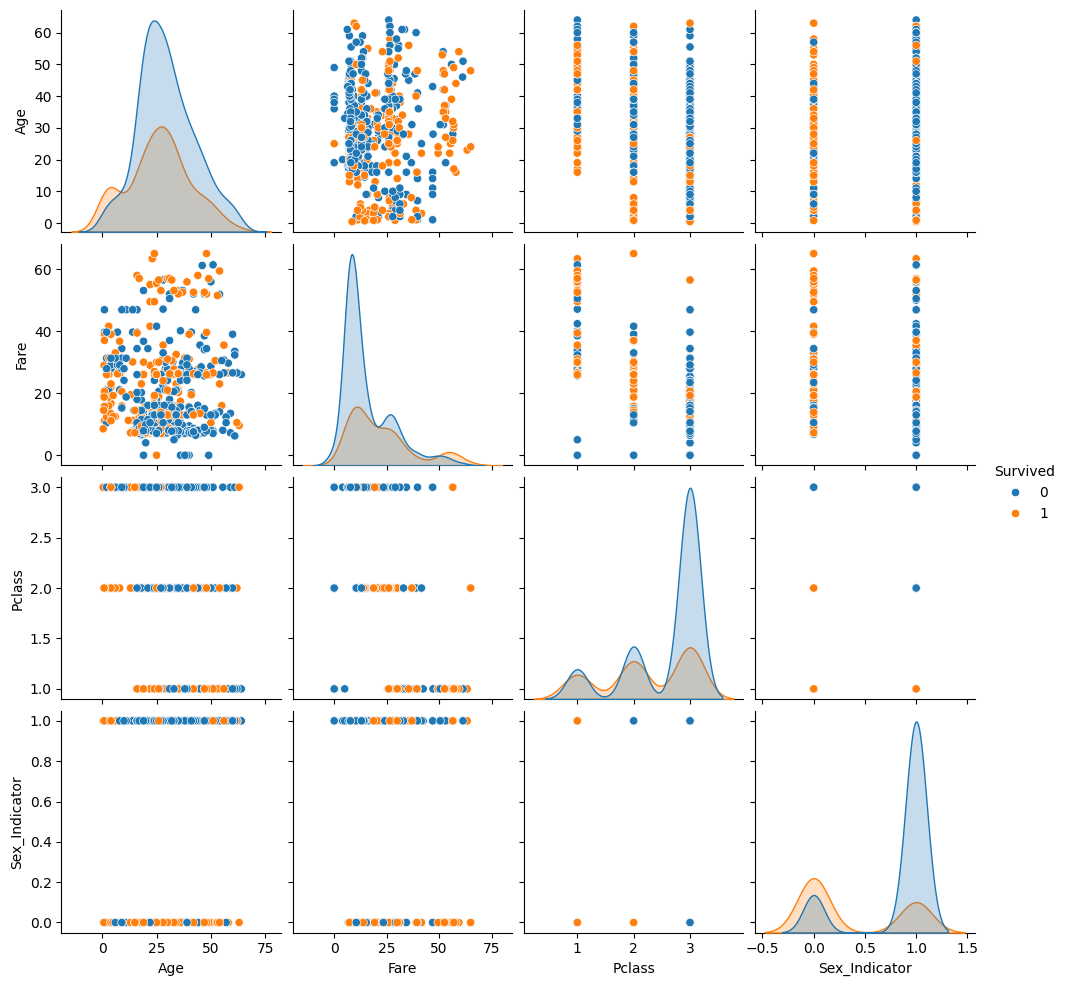

In [179]:
# 使用 pairplot 绘制多个变量之间的关系
# sns.pairplot(titanic_train, hue='Survived', vars=['Age', 'Fare', 'Pclass', 'Sex_Indicator'])
sns.pairplot(titanic_train_cleaned_iqr, hue='Survived', vars=['Age', 'Fare', 'Pclass', 'Sex_Indicator'])
plt.show();

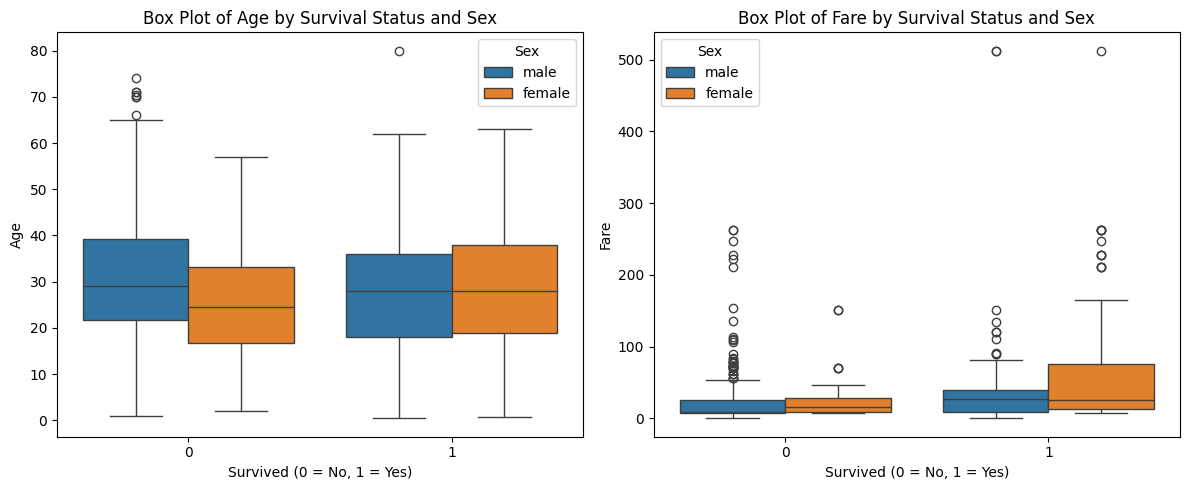

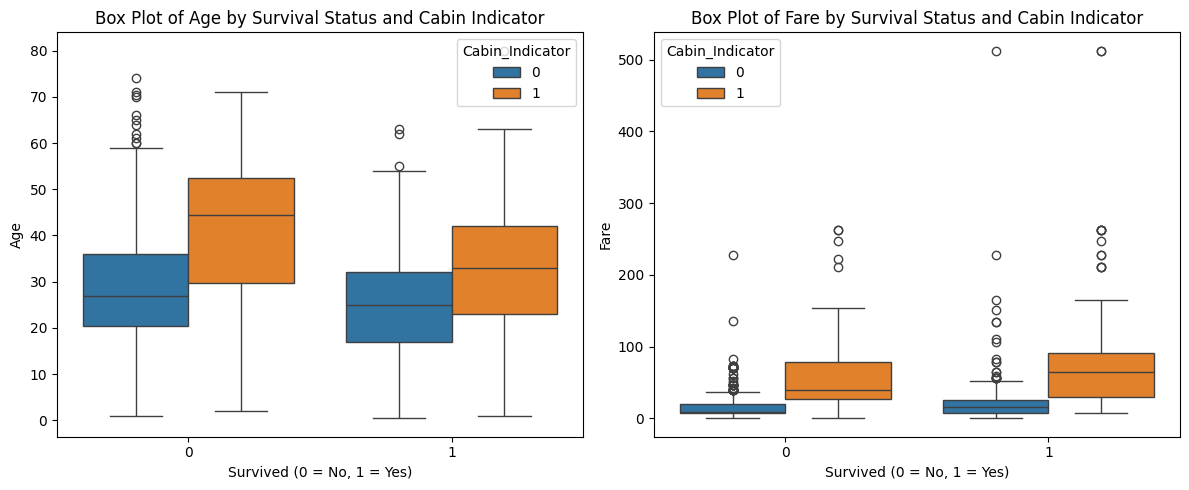

In [180]:
# 定义要绘制的特征
features = ['Age', 'Fare']

# 定义绘制盒须图的函数
def plot_boxplots(data, features, hue=None, title_suffix=''):
    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(12, 5))
    
    for idx, feat in enumerate(features):
        sns.boxplot(x='Survived', y=feat, data=data, ax=axes[idx], hue=hue)
        axes[idx].set_xlabel('Survived (0 = No, 1 = Yes)')
        axes[idx].set_ylabel(feat)
        axes[idx].set_title(f'Box Plot of {feat} by Survival Status {title_suffix}')

    plt.tight_layout()  # 调整布局
    plt.show()


# 绘制盒须图（按性别分组）
plot_boxplots(titanic_train, features, hue='Sex', title_suffix='and Sex')
# plot_boxplots(titanic_train_cleaned_iqr, features, hue='Sex', title_suffix='and Sex')

# 绘制盒须图（按舱位指示分组）
plot_boxplots(titanic_train, features, hue='Cabin_Indicator', title_suffix='and Cabin Indicator')
# plot_boxplots(titanic_train_cleaned_iqr, features, hue='Cabin_Indicator', title_suffix='and Cabin Indicator')

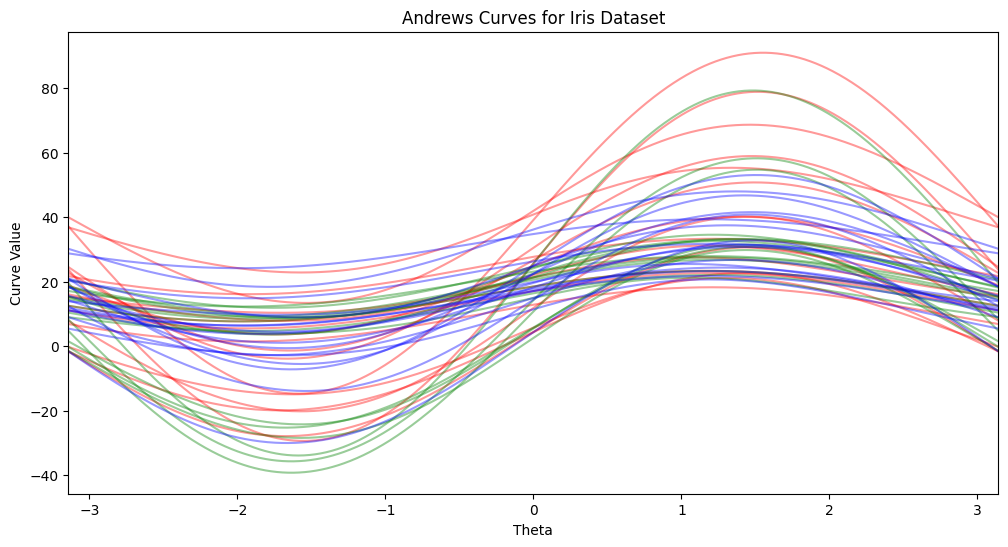

In [181]:
# 定义 Andrews 曲线函数
def andrews_curve(x, theta):
    curve = list()
    for th in theta:
        x1 = x[0] / np.sqrt(2)
        x2 = x[1] * np.sin(th)
        x3 = x[2] * np.cos(th)
        x4 = x[3] * np.sin(2. * th)
        x5 = x[4] * np.sin(th)  # 使用 Cabin_Indicator
        curve.append(x1 + x2 + x3 + x4 + x5)
    return curve

# samples = titanic_train[["Age", "Fare", "Pclass", "Survived", "Cabin_Indicator"]].values
samples = titanic_train_cleaned_iqr[["Age", "Fare", "Pclass", "Survived", "Cabin_Indicator"]].values
accuracy = 1000
theta = np.linspace(-np.pi, np.pi, accuracy)

# 绘制 Andrews 曲线
plt.figure(figsize=(12, 6))

# 绘制 Setosa
for s in samples[:20]:  # Setosa
    plt.plot(theta, andrews_curve(s, theta), "r", alpha=0.4)

# 绘制 Versicolor
for s in samples[50:70]:  # Versicolor
    plt.plot(theta, andrews_curve(s, theta), "g", alpha=0.4)

# 绘制 Virginica
for s in samples[100:120]:  # Virginica
    plt.plot(theta, andrews_curve(s, theta), "b", alpha=0.4)

plt.xlim(-np.pi, np.pi)
plt.title("Andrews Curves for Iris Dataset")
plt.xlabel("Theta")
plt.ylabel("Curve Value")
plt.show()

In [182]:
titanic_train_cleaned_iqr.to_csv("titanic_train_cleaned.csv", index=False)
titanic_test.to_csv("titanic_test.csv", index=False)

In [183]:
archive_train = pd.read_csv("archive/churn-bigml-80.csv")
archive_test = pd.read_csv("archive/churn-bigml-20.csv")
archive_train.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [184]:
archive_train.info()
archive_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,42.521018,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,408.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [185]:
archive_train.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [192]:
Internationa_plan_map = {'No' : 0, 'Yes' : 1}
Voice_mail_plan_map = {'No' : 0, 'Yes' : 1}
Churn_map={False : 0, True : 1}


archive_train['Internationa_plan_Indicator'] = archive_train['International plan'].map(Internationa_plan_map)
archive_train['Voice_mail_plan_Indicator'] = archive_train['Voice mail plan'].map(Voice_mail_plan_map)
archive_test['Internationa_plan_Indicator'] = archive_test['International plan'].map(Internationa_plan_map)
archive_test['Voice_mail_plan_Indicator'] = archive_test['Voice mail plan'].map(Voice_mail_plan_map)
archive_train['Churn_Indicator'] = archive_train['Churn'].map(Churn_map)
archive_test['Churn_Indicator'] = archive_train['Churn'].map(Churn_map)
archive_train.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,Internationa_plan_Indicator,Voice_mail_plan_Indicator,Churn_Indicator
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,...,91,11.01,10.0,3,2.70,1,False,0,1,0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,False,0,1,0
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,False,0,0,0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,False,1,0,0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,False,1,0,0


In [187]:
def remove_outliers_iqr(data, features):
    for feature in features:
        # 计算 Q1 和 Q3
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # 计算下限和上限
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 删除异常值
        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    
    return data
    
def remove_outliers_zscore(data, features, threshold=3):
    for feature in features:
        # 计算均值和标准差
        mean = data[feature].mean()
        std_dev = data[feature].std()
        
        # 计算 Z-score
        z_scores = (data[feature] - mean) / std_dev
        
        # 删除异常值
        data = data[np.abs(z_scores) < threshold]
    
    return data


# 使用示例
features = ['Total day minutes', 'Total intl calls','Total day charge','Total eve charge','Total night charge','Total intl charge']
# archive_cleaned_train = remove_outliers_iqr(archive_train, features)
archive_cleaned_train = remove_outliers_zscore(archive_train, features)
# 打印数据集的形状
print(archive_cleaned_train.shape, archive_train.shape)

(2579, 23) (2666, 23)


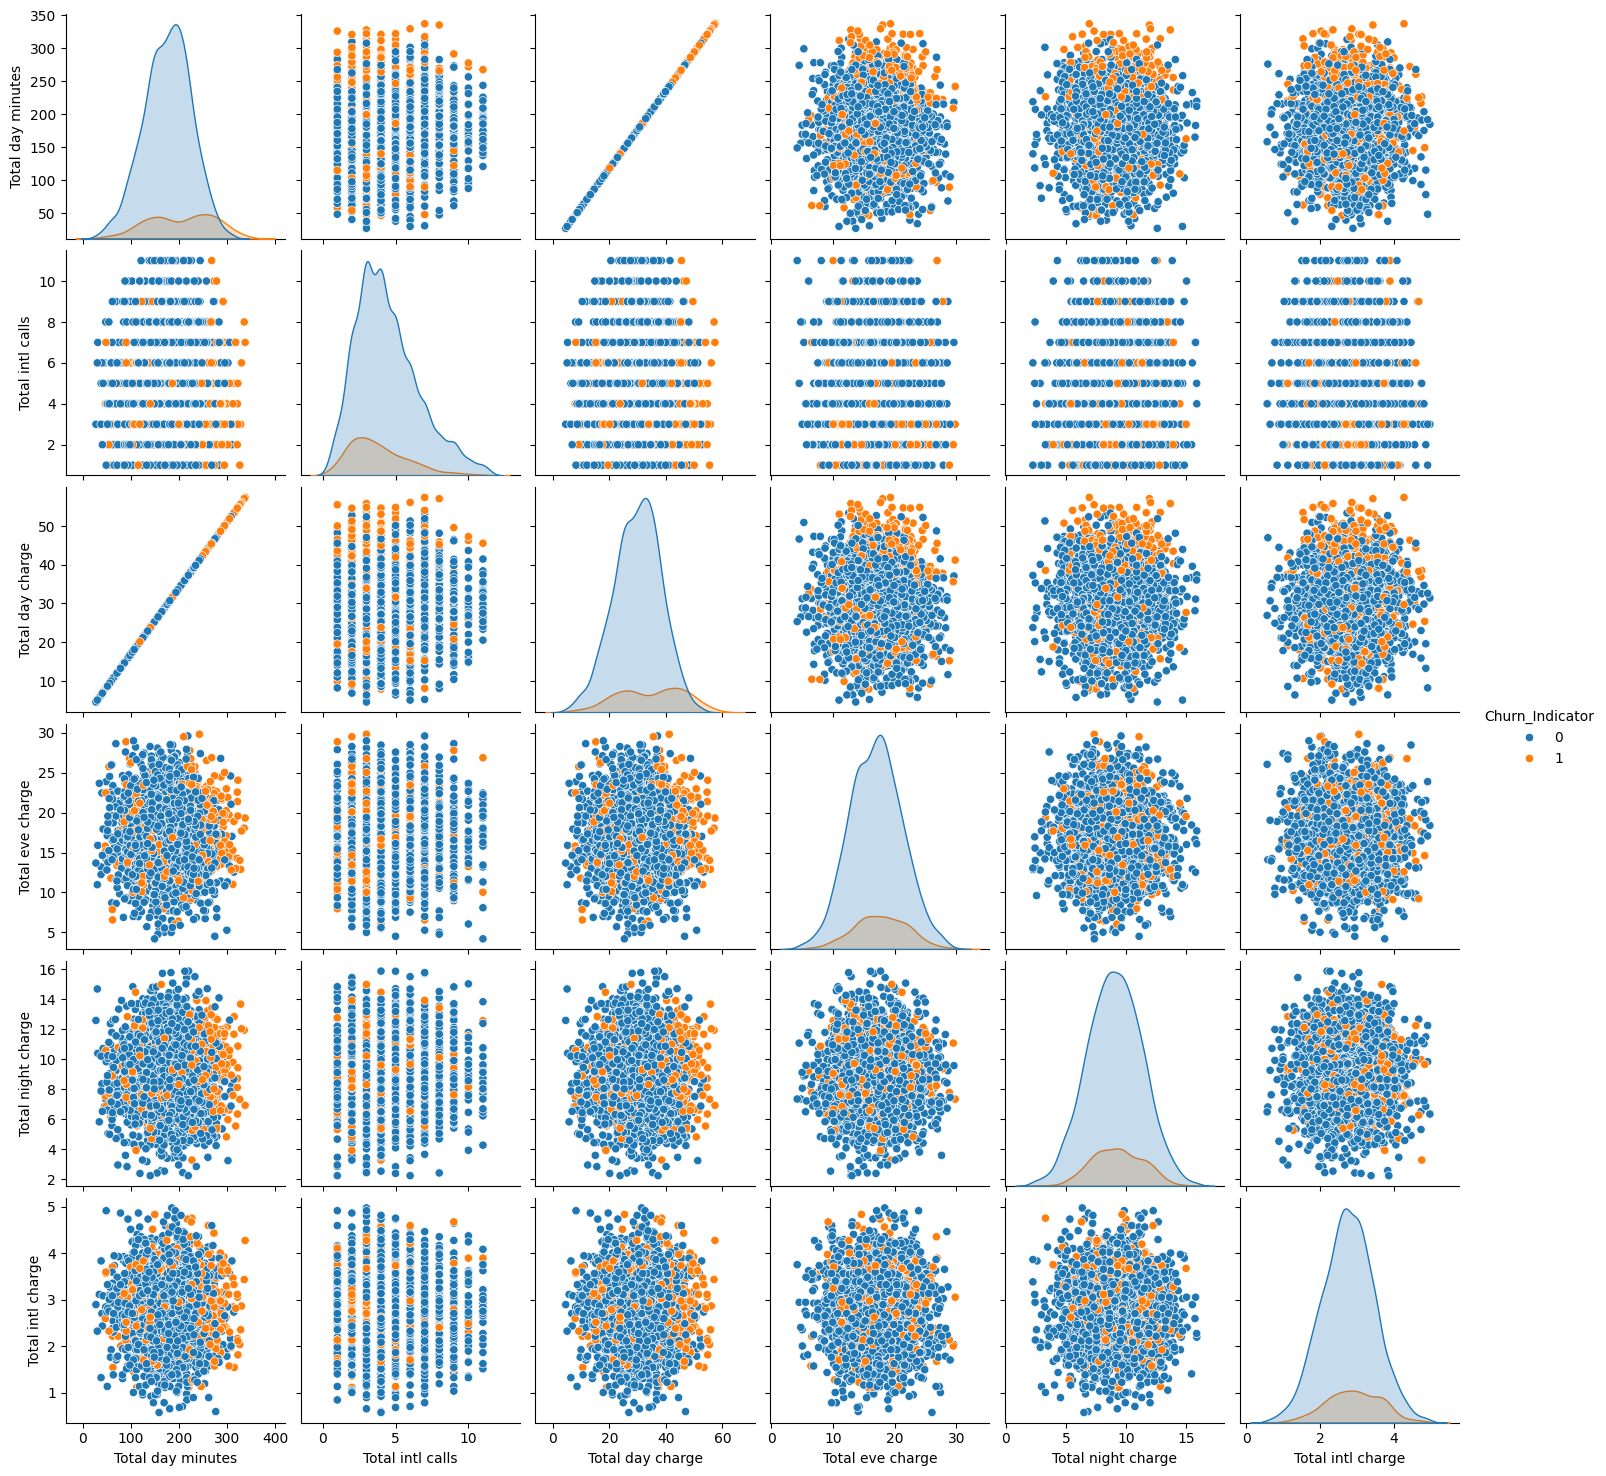

In [188]:
# sns.pairplot(archive_train, hue='Churn_Indicator', vars=features)
sns.pairplot(archive_cleaned_train, hue='Churn_Indicator', vars=features)
plt.show();

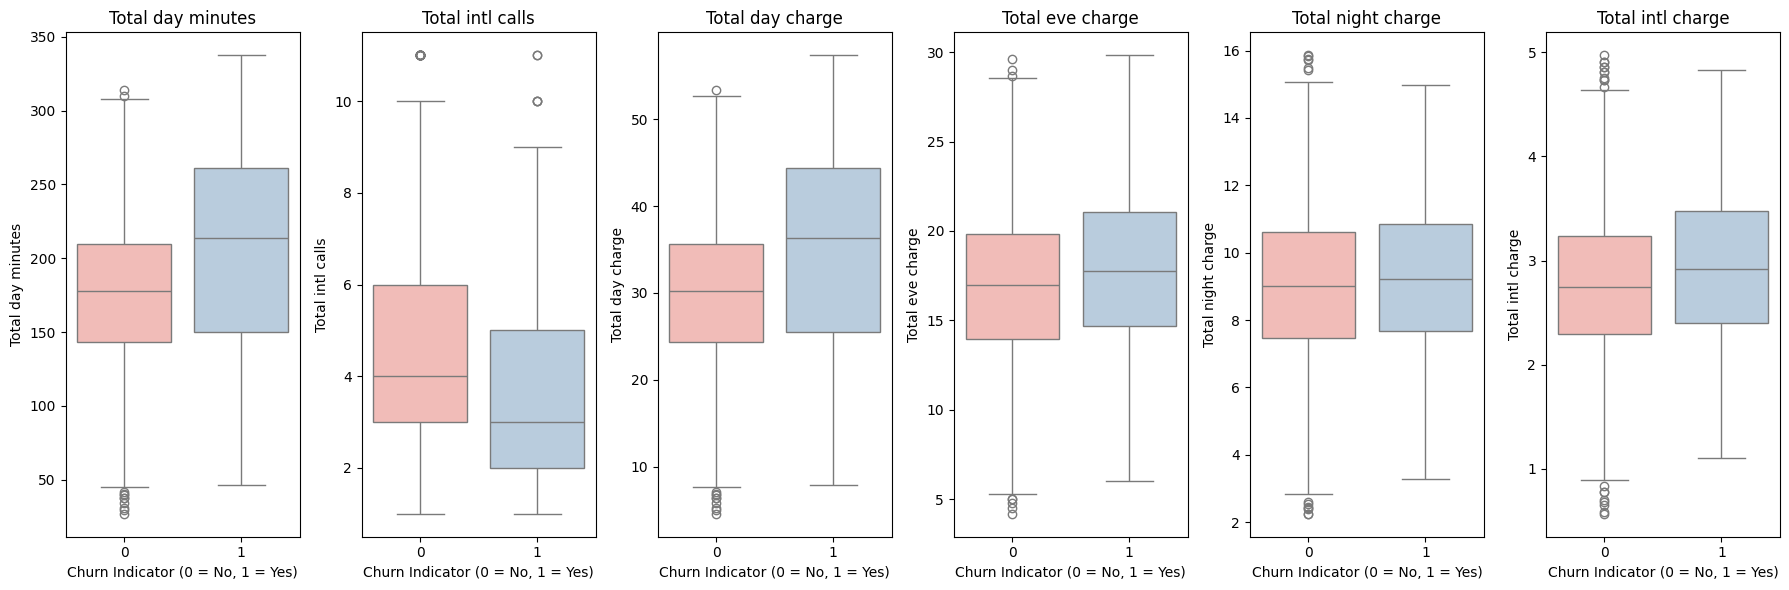

In [189]:
# 创建一个绘图函数
def plot_boxplots(data, features, palette='Pastel1'):
    # 创建子图
    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(18, 6))
    
    for idx, feature in enumerate(features):
        sns.boxplot(x='Churn_Indicator', y=feature, data=data, ax=axes[idx], hue='Churn_Indicator', palette=palette, legend=False)
        axes[idx].set_xlabel('Churn Indicator (0 = No, 1 = Yes)')
        axes[idx].set_ylabel(feature)
        axes[idx].set_title(f'{feature}')

    plt.tight_layout()  # 调整布局
    plt.show()

# 绘制盒须图，使用 Pastel1 调色板
# plot_boxplots(archive_train, features, palette='Pastel1')
plot_boxplots(archive_cleaned_train, features, palette='Pastel1')


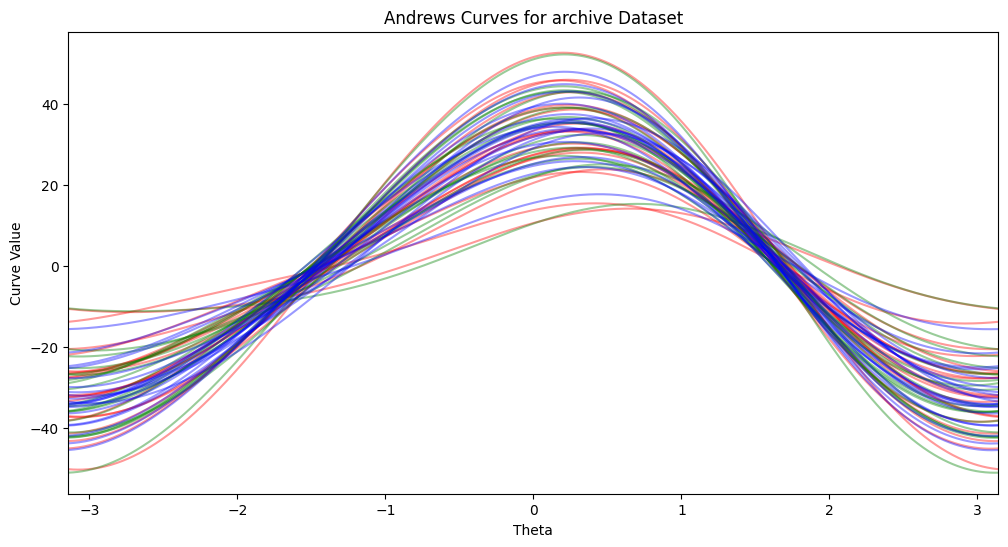

In [190]:
samples = archive_cleaned_train[['Internationa_plan_Indicator', 'Total intl calls','Total day charge','Total intl charge','Churn_Indicator']].values
accuracy = 1000
theta = np.linspace(-np.pi, np.pi, accuracy)

# 绘制 Andrews 曲线
plt.figure(figsize=(12, 6))

# 绘制不同类别的样本
# 假设样本的索引分别对应不同的类别
for s in samples[:20]:  # 选择前 20 个样本
    plt.plot(theta, andrews_curve(s, theta), "r", alpha=0.4)

for s in samples[50:70]:  # 选择第 50 到 70 个样本
    plt.plot(theta, andrews_curve(s, theta), "g", alpha=0.4)

for s in samples[100:120]:  # 选择第 100 到 120 个样本
    plt.plot(theta, andrews_curve(s, theta), "b", alpha=0.4)

plt.xlim(-np.pi, np.pi)
plt.title("Andrews Curves for archive Dataset")
plt.xlabel("Theta")
plt.ylabel("Curve Value")
plt.show()

In [193]:
archive_cleaned_train.to_csv("archive_cleaned_train.csv", index=False)
archive_test.to_csv("archive_test.csv", index=False)